# Group 49 Project Proposal: User Knowledge

***

### Introduction

##### *Dataset Information*

We chose the User Knowledge dataset, which gives the students’ knowledge level per user (very low, low, middle, or high) based on their study times and exam performances (given as decimals between 0 and 1). This dataset was from a Ph.D. Thesis project looking at the undergraduates' knowledge status about the subject of Electrical DC Machines in Gazi University, Turkey (Kahraman et al., 2013).

We will create a **classification model** to predict knowledge level by taking into account the amount of time spent studying as well as the exam performances for each student. We are using classification because we are placing individuals into a finite number of categories (e.g. tall vs. short) as opposed to assigning continuous labels (e.g. height in centimetres), which would be more suited for a regression model. 

Specifically, the K-nearest neighbours algorithm will be used to predict categorical labels of new observations. As we learned in class, knn classification takes the most common of the nearest neighbours to assign a label; the most accurate number of neighbours will be determined via cross validation.

...

##### *Predictive Question*

The question we will try to answer with our project:
**Given the amount of time spent studying and the exam score of the students, does the student have very low, low, middle, or high knowledge?**

Intuitively, we predict that the exam performance variables will be more relevant to our study as it is usually the best available indicator of knowledge level. As an example, this course utilizes exams which make up a large majority of our grade in order to test our knowledge on Introductory Data Science in the R language. However, we will still analyze all variables first in order to avoid any bias and empirically determine the best predictors to utilize in our model. 

We will use the training dataset to answer this question and we will test the accuracy of our model using the test data. The initial split was already conducted on the dataset file. All graphs will be given descriptive titles and axes labels so that they are readable and useful for people; vague labels would make a graph unusable as the audience would not know what it is visualising.

...

##### *The Significance of Our Research*
Research on how to improve knowledge levels of specific subjects is important to help inform instructors on the best way to inspire growth in students, as well as allow students to understand the benefits of good study habits and exams. Instructors can use this research to help them decide if they want to include exams for certain subjects as well as what type of study materials to provide. Students can use this research to ascertain the subjects to focus on and how much value to place on exams. Knowledge level may vary with different learning strategies and exam scores across different subjects and even instructor (some instructors may create exams that promote more conceptual learning as opposed to rote memorisation). Since we do not have a large dataset with many differentiated subjects and their associated exam / teaching styles, we cannot address this gap.


***



### Preliminary Exploratory Data Analysis

#### Loading Libraries
Loading all libraries that might be required at some point later on in the analysis. 

In [1]:
library(readxl)  #for excel sheet read system
library(DBI)  #for Reading Data from SQLite database
library(dbplyr)  #SQL Database queries functions
library(RSQLite)  #RSQL Database queries functions
library(RPostgres) # RPostgres Database functions
library(tidyverse)  #most of our tidyverse functions 
library(scales)  #for labeling comma function and log scales
library(RColorBrewer)  #color palette (includes color-blind options)
library(repr)  #ggplot visualization + options(repr.plot.width=8, repr.plot.height=7)
library(rsample) #create different types of resamples and corresponding classes for their analysis
library(tidymodels) #is a collection of packages for modeling and machine learning using tidyverse principles

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::ident()  masks dbplyr::ident()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::sql()    masks dbplyr::sql()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ recipes      1.0.1
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0

── Conflicts ────────────────────────────────────────

#### Reading the dataset into R 

We first began by setting the seed in order to maintain reproducibility for the whole project. We will be setting the same seed, "2", throughout the project when some randomization action occurs. 

To read the training dataset into R, we used the read_csv function and selected the relevant columns to minimise any unnecessary data being run. This was repeated for the testing dataset. 

In the code below, we deleted the first row of the training data because it contains all zeroes in its observations which interferes with the cross-validation conducted later. Furthermore, we can omit rows with only zeroes since they are likely incorrect data (we can expect none of the students that stayed in the course would spend no time studying and get 0 on exams too, and if they did, they would be an outlier).

In [20]:
set.seed(2)

training_data <- read_csv("knowledge_training_data.csv") |>
    select("STG", "STR", "SCG", "LPR", "PEG", "UNS") |>    
    tail(-1)



testing_data <- read_csv("knowledge_testing_data.csv") |>
    select("STG", "STR", "SCG", "LPR", "PEG", "UNS")

New names:
• `` -> `...7`
• `` -> `...8`
Rows: 258 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (5): STG, SCG, STR, LPR, PEG
lgl (2): ...7, ...8

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...7`
• `` -> `...8`
Rows: 145 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (5): STG, SCG, STR, LPR, PEG
lgl (2): ...7, ...8

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Cleaning and Wrangling into a Tidy Format
We believe this data is relatively tidy because each variable forms a column, each observation forms a row, and each cell is a single measurement. 

However, slight modifications were conducted on both datasets (training and testing). 

The mutate function was used to change the UNS column data type to factor instead of character, since each individual is sorted into one of four categories (Very Low, Low, Middle, High) and the column is required to be a factor for K-nn classification. This column's class needs to be factor in order for it to act as a categorical statistical variable in our model.

The observations under the UNS column were also modified from the "very_low" category into the more human-readable "Very Low" category. 

Furthermore, the data was checked for any missing data (NA) and none are present. 

In [21]:
training_data[training_data == "very_low"]<- "Very Low" 

training_data <- training_data |>
                mutate(UNS = factor(UNS))

testing_data <- testing_data |>
                mutate(UNS = factor(UNS))

In [22]:
sum(is.na(training_data))

[1] 0

#### Exploratory Data Analysis

We took a count of our training data into a table that groups the data by the UNS (User Knowledge Level) column by using the group_by() function to separate UNS into each level (Very Low, Low, Middle, High) and the summarise() function to get a count for each level. 

Next, we visualised this data with a bar chart with User Knowledge Level on the x-axis and the student count on the y-axis. By using a bar graph showing how many students from the training data are at each knowledge level, it helps to better visualise and compare the number of students in each group.

We utilized the training data for this part and future development of our model because if we included the testing data, the model would report a higher accuracy than it normally should. The testing data would introduce bias and affect the model's predicting capabilities on the testing data. The testing and training data should have about equal ratios of students in each category.

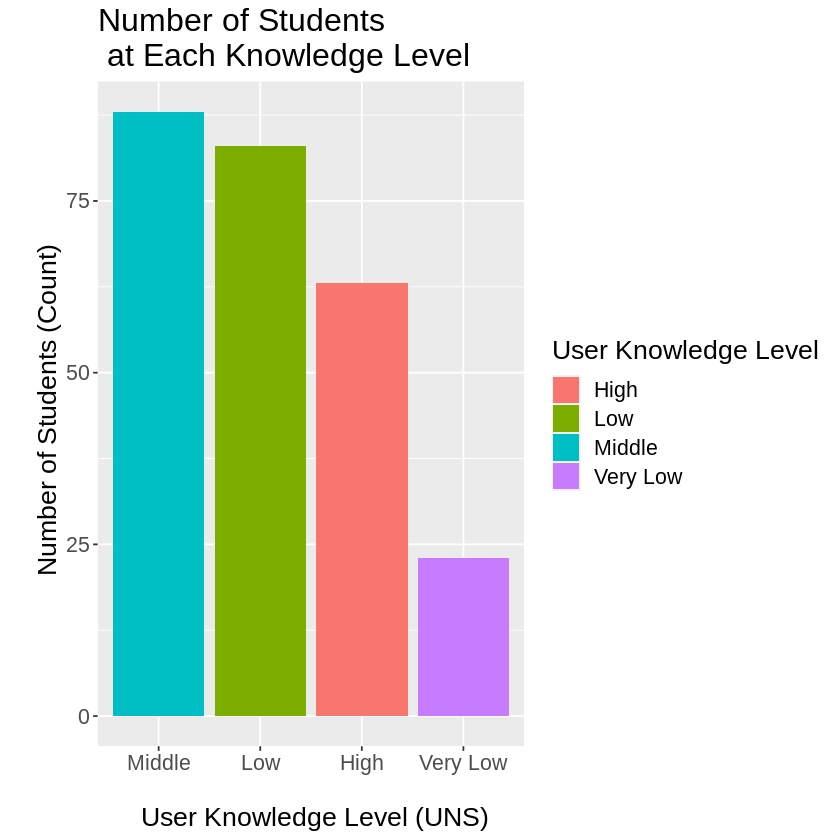

In [5]:
training_count <- training_data |>
                    group_by(UNS) |>
                    summarize(n = n())
              
training_count_bar <- training_count |>
        ggplot(aes(x = reorder(UNS, -n), y = n, fill = UNS)) +
        geom_bar(stat = "identity") +
        labs(x = "\n User Knowledge Level (UNS)", y = "\n Number of Students (Count)", 
             fill = "User Knowledge Level", title = "Number of Students \n at Each Knowledge Level") +
        theme(text = element_text(size = 16))

training_count_bar

**Figure 1:** Bar Chart of the Number of Students at Each Knowledge Level

Based on Figure 1, we notice that most people are categorized into the Middle Knowledge level in this dataset. This demonstrates that our model is likely to have to sort and predict observations from that category most often. 


Next, we decided to make an initial plot to understand the effects that studying and exam performance had on user knowledge level. To do this, we first took the average of studying time and exam performance of both direct and related objects, respectively. We then plotted the data using a scatterplot with coloured points representing the knowledge level, with a legend showing which knowledge level each colour represents.  

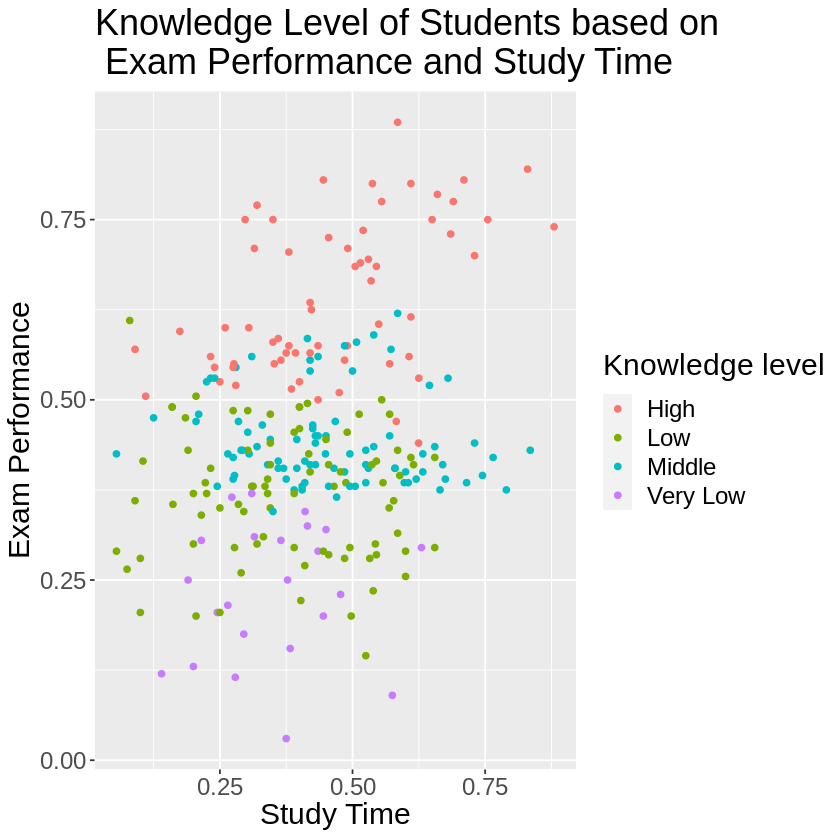

In [6]:
training_mutated <- training_data |>
    mutate(study_avg = ((STG + STR)/2)) |>
    mutate(exam_avg = ((LPR + PEG)/2))

training_avg_plot <- training_mutated |>
                ggplot(aes(x = study_avg, y = exam_avg, color = UNS)) +
                geom_point() +
                labs(x = "Study Time", y = "Exam Performance", color = "Knowledge level", 
                     title = "Knowledge Level of Students based on \n Exam Performance and Study Time") +
                theme(text = element_text(size=18))
training_avg_plot

**Figure 2**: Scatter Plot of Knowledge Level of Students based on Exam Performance and Study Time

The Figure 2 above showed some distinct clusters, although there appears to be significant overlap in the middle of the plot, especially for the middle and low knowledge levels, which might be challenging for our classifier. Picking the most suitable predictors will be necessary to minimize this overlap and achieve a more accurate model.

#### Is **study time** or **exam performance** a better predictor for knowledge level?
Figure 3 and Figure 4 below are used to visually gauge which aggregate variable (exam performance or study time) are more indicative of the knowledge level. 

We used box and whisker plots for this comparison because they show the spread of the data and where there is a higher concentration of data points (shows levels) as opposed to just comparing the number of points in each category. This way we can gauge precision and how differentiated each level is and determine which predictors affect knowledge level more strongly.


In [7]:
training_exam_avg_plot <- training_mutated |>
                ggplot(aes(x = reorder(UNS,-exam_avg), y = exam_avg, color = UNS)) +
                geom_boxplot() +
                labs(x = "Knowledge Level", y = "Average Exam Performance",
                     title = "Knowledge Level vs. Average Exam Performance") +
                theme(text = element_text(size=18), legend.position = "none")

training_study_avg_plot <- training_mutated |>
                        ggplot(aes(x = reorder(UNS, -exam_avg), y = study_avg, color = UNS)) +
                        geom_boxplot() +
                        labs(x = "Knowledge Level", y = "Average Degree of Study Time", color = "Knowledge level", 
                             title = "Knowledge Level vs. \n Average Degree of Study Time") +
                        theme(text = element_text(size=18), legend.position = "none")

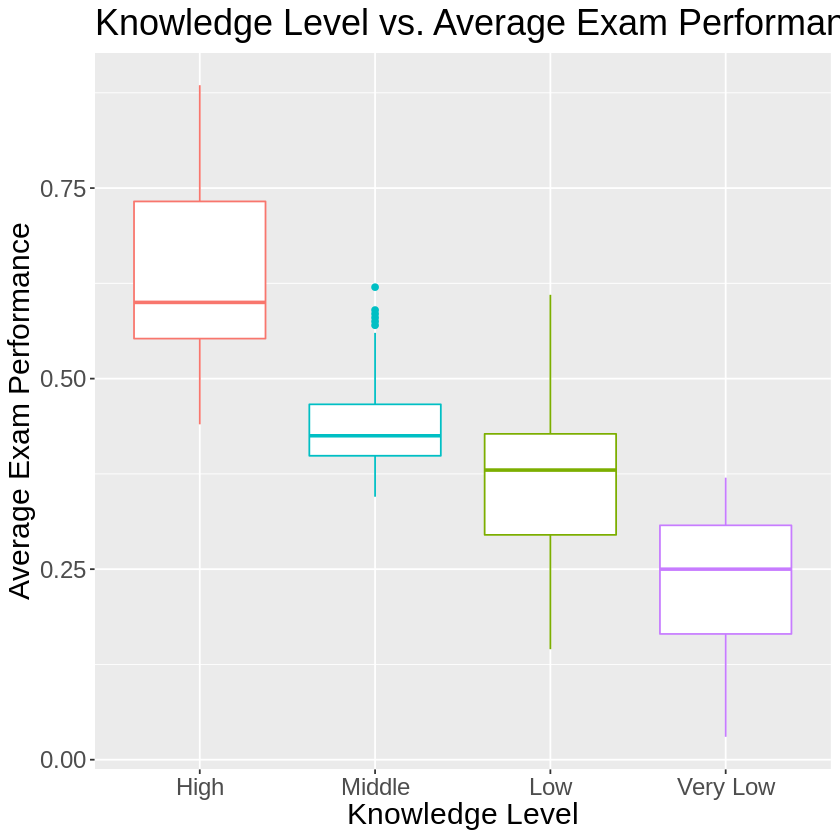

In [8]:
training_exam_avg_plot

**Figure 3:** Box Plot of the Knowledge Level vs. Average Exam Performance

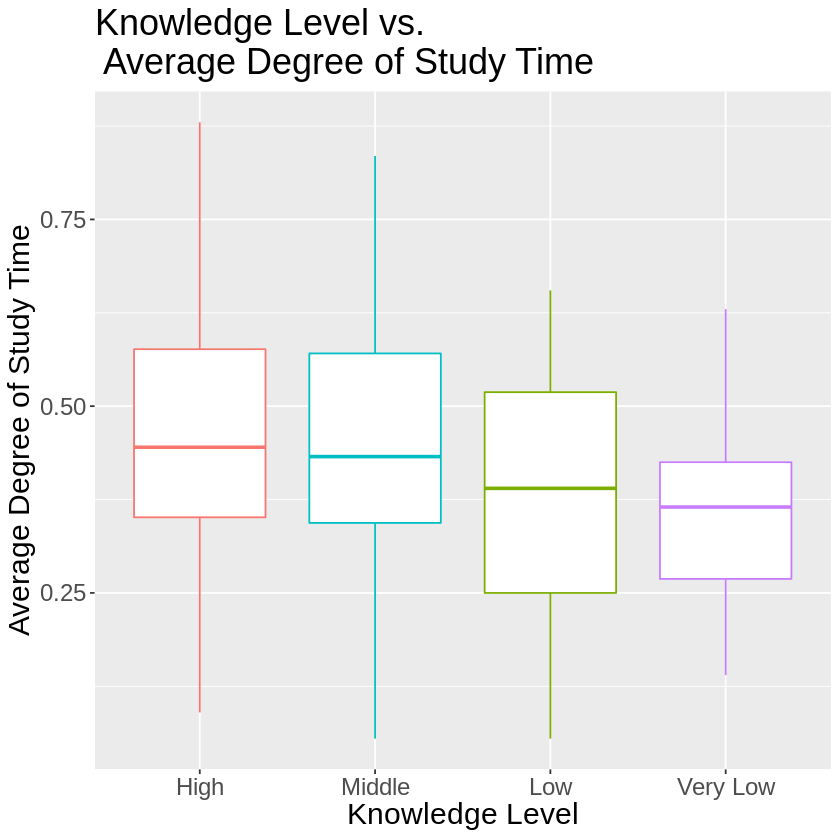

In [9]:
training_study_avg_plot

**Figure 4:** Box Plot of the Knowledge Level vs. Average Degree of Study Time

Looking at both Figure 3 and 4 above, exam performance looks to be the better indicator as the spread of the points are more precise and differentiated between knowledge levels with a stronger positive correlation as opposed to the weak (widely spread) positive correlation seen with study time. This concurs with what we intuitively stated to be the better predictors (exam performance) in the introduction section. Overall, our initial analysis tells us exam performance (both of goal object and those related objects with the goal object) is a better predictor of knowledge level. Therefore, we will be utilizing those predictors to develop our model.

***
### Model Method

The data analysis method will follow the classification data flow and utilize the tidy models library to train, fit, and test our model in order to predict categorical observations for our question. The variables in this dataset categorise different studying strategies and exam performance, as well as repetition. We will be utilizing the exam performance variables listed below as they are the most relevant and applicable to developing a reasonable model that provides rigorous predictions for our question. We excluded "degree of repetition number of user for goal object materials" because it is unclear what this is a measure of, even after looking at the available metadata. We also excluded the study time variables (explained above).

* ~~The degree of study time for goal object materials (STG)~~
* ~~The degree of study time of user for related objects with goal object (STR)~~
* ~~The degree of repetition number of user for goal object materials (SCG)~~ 
* ##### The exam performance of user for related objects with goal object (LPR)
* ##### The exam performance of user for goal objects (PEG)
* ##### The knowledge level of user (UNS)  

A method for visualizing the results will be to create a plot showing the observations of the test data similar to the plot "Knowledge Level of Students based on Exam Performance and Study Time", but as a cloud plot to show what our classifier would have predicted an observation in a specific area to be. This will be similar to Figure 5.15 found in the course textbook.   


***

### Developing our Model and Predicting Testing Dataset

#### Finding Best K-value

It is necessary to set seed at the start before any random draw in order to make sure that we get the same results for the randomization action which was done when needed throughout this section.

We create the first recipe for user knowledge using the target variable UNS and predictors, LPR and PEG, using the training data. This is required to prepare the recipe that will be followed for our model. In the recipe, we scaled all predictors because the classifier predicts classes by identifying observations nearest to it, so large scale variables will have a much larger effect than those with small scale (this depends on the context). We also centred all predictors to confirm that the mean and standard deviation are standardized too. Overall, it is good practice to scale and center most datasets in the recipe phase of your model. 


In [10]:
uk_recipe <- recipe(UNS ~LPR + PEG, data = training_data) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())

Next, we used multiple different train/validation splits to ensure we get a better estimate of accuracy and thus a better choice of the number of K neighbours for the overall set of training data. This will be utilized in the cross-validation steps and tuning of our model. We chose 5 folds to minimize computing power required while still remaining within the suggested range of 5-10. The target variable, "UNS", was used as the strata.

In [11]:
set.seed(2)

uk_fold <- vfold_cv(training_data, v = 5, strata = UNS)
gridvals <- tibble(neighbors = seq(1,25))

Afterwards, we trained the classifier by creating a model specification and fitting both the spec and recipe into a workflow for K-nearest neighbours classification. This was done by setting the correct values for engine and mode. 

In order to find the best value of K, we used neigbors = tune() in the spec and tune_grid(...) in the workflow. The collect_metrics() aggregates the mean and standard error of the classifier’s validation accuracy across the folds, which we then filter for the accuracy values of each k neighbour. 

Later in the project, we will make a final workflow using this ideal K determined from the tuning procedure. 

In [12]:
set.seed(2)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

uk_workflow <- workflow() |>
                add_recipe(uk_recipe) |>
                add_model(knn_spec) |>
                tune_grid(resamples = uk_fold, grid = gridvals) |>
                collect_metrics() |>
                filter(.metric == "accuracy")

Next, we created a plot of the cross validation conducted in the coding cell above to see which K value we should use to provide the highest accuracy.

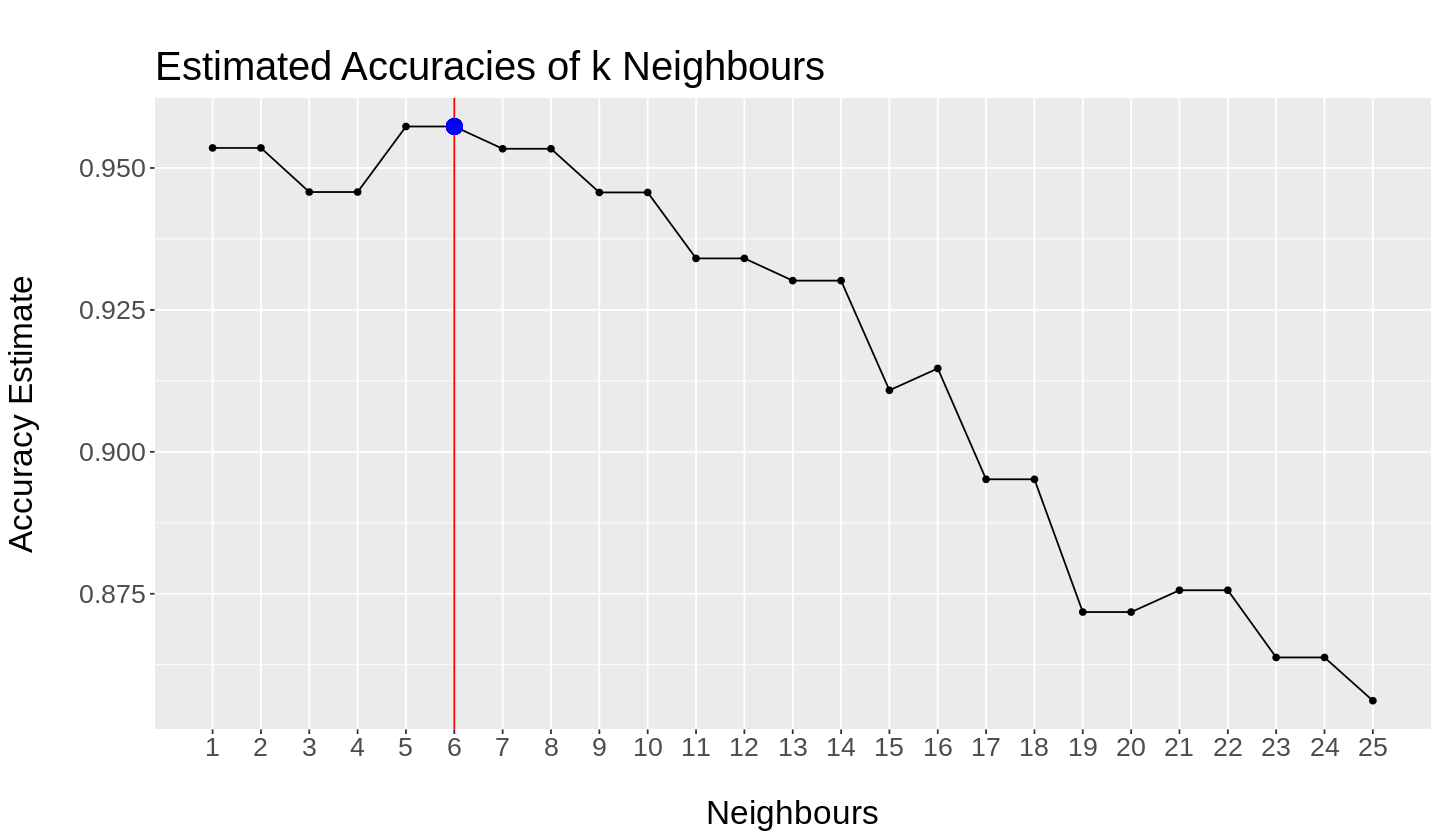

In [13]:
options(repr.plot.width = 12, repr.plot.height = 7)

cross_val_plot <- uk_workflow |>
                    ggplot(aes(x= neighbors, y =mean)) +
                    geom_point() +
                    geom_line() +
                    geom_vline(xintercept = 6, colour = "red") +
                    geom_point(aes(x = 6, y = 0.957306525512963), size = 4, colour = "blue") +
                    labs(x = "\nNeighbours", y = "Accuracy Estimate\n", title = "\nEstimated Accuracies of k Neighbours") +
                    scale_x_continuous(limits = c(1, 25), breaks = seq(1, 25), minor_breaks = seq(1, 25, 1)) +
                    theme(text = element_text(size = 20), plot.caption = element_text(size = 20, hjust = 0))
cross_val_plot

**Figure 5:** Line Plot of the Estimated Accuracies of k Neighbours

Using Figure 5, it can be seen that K = 6 would be a reasonable choice because the neighbouring points are relatively stable (i.e. the line is flat at this section), which means that changing the value to a nearby one (like from K=6, to 5 or 7) doesn't decrease the accuracy excessively. This is the point that is highlighted in blue. Therefore, this value appears to be reliable in the presence of uncertainty. Furthermore, this value isn't large enough that it starts becoming prohibitive in training our model due to needing disproportionate computing power. A K too high would result in underfitting the model (predictions not trained to be accurate enough to the data) while a K too low would result in overfitting the model (predictions too precisely fitted to the training data; leaves no room for variation in new observations).

...

#### Training our Final Model

Now that we found the ideal K neighbour value (K = 6), we will create a new model. This will be the final and most accurate classification model in our project.

To develop this model, the specification of the model were changed to using that ideal value of K neighbour (K = 6) as that neighbors value. Then we simply inputted the recipe and new model specifications into a workflow that fitted the training data.  

In [14]:
set.seed(2)

knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
  set_engine("kknn") |>
  set_mode("classification")

uk_fit <- workflow() |>
  add_recipe(uk_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = training_data)

...

#### Predicting and Comparing Accuracy of the Model

Once we had our model, then we utilized it to predict the UNS values of our testing dataset and bind that prediction column to the testing dataset. 

In [15]:
set.seed(2)

uk_predictions <- predict(uk_fit, testing_data) |> 
    bind_cols(testing_data)

Now that our model predicted the values of testing dataset, we want to compare the accuracy of those predictions to the true values in the dataset. This was conducted by the metrics functions to get a quantitative accuracy value, as well as the confusion matrix to view the negative/incorrect predictions conducted by our model.

In [16]:
set.seed(2)

uk_acc <- uk_predictions |> 
    metrics(truth = UNS, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)

uk_cm <- uk_predictions |> 
    conf_mat(truth = UNS, estimate = .pred_class)

**Table 1:** Accuracy of our Model using Testing Dataset 

In [17]:
uk_acc

.metric,.estimate
<chr>,<dbl>
accuracy,0.9724138


**Table 2:** Confusion Matrix on the Testing DataSet

In [18]:
uk_cm

          Truth
Prediction High Low Middle Very Low
  High       39   0      0        0
  Low         0  45      1        2
  Middle      0   1     33        0
  Very Low    0   0      0       24

Table 1 shows that the accuracy of our model is quite high at 97.2%. The confusion matrix in Table 2 shows how many predicted values (across) match up with the actual values (vertical). We see that almost all the predictions are accurate (141 predictions consistent with the actual values and 4 incorrect predictions), meaning our model is working how we want it to.

Overall, we see that almost all the predictions are accurate (consistent with the actual values), meaning our model is working how we want it to.

...

#### Visualizing the Model's Analysis

In order to visualize our model's prediction capabilities, we will generate a cloud plot of which the code was copied and adapted from section 5.8 of the DSCI 100 course textbook (Timbers et al., 2022). The adaptation was done by inputting our respective variables instead of the placeholders, such as the testing dataset for the data parameter, the LPR and PEG as the predictor parameter, and the correct labels.  

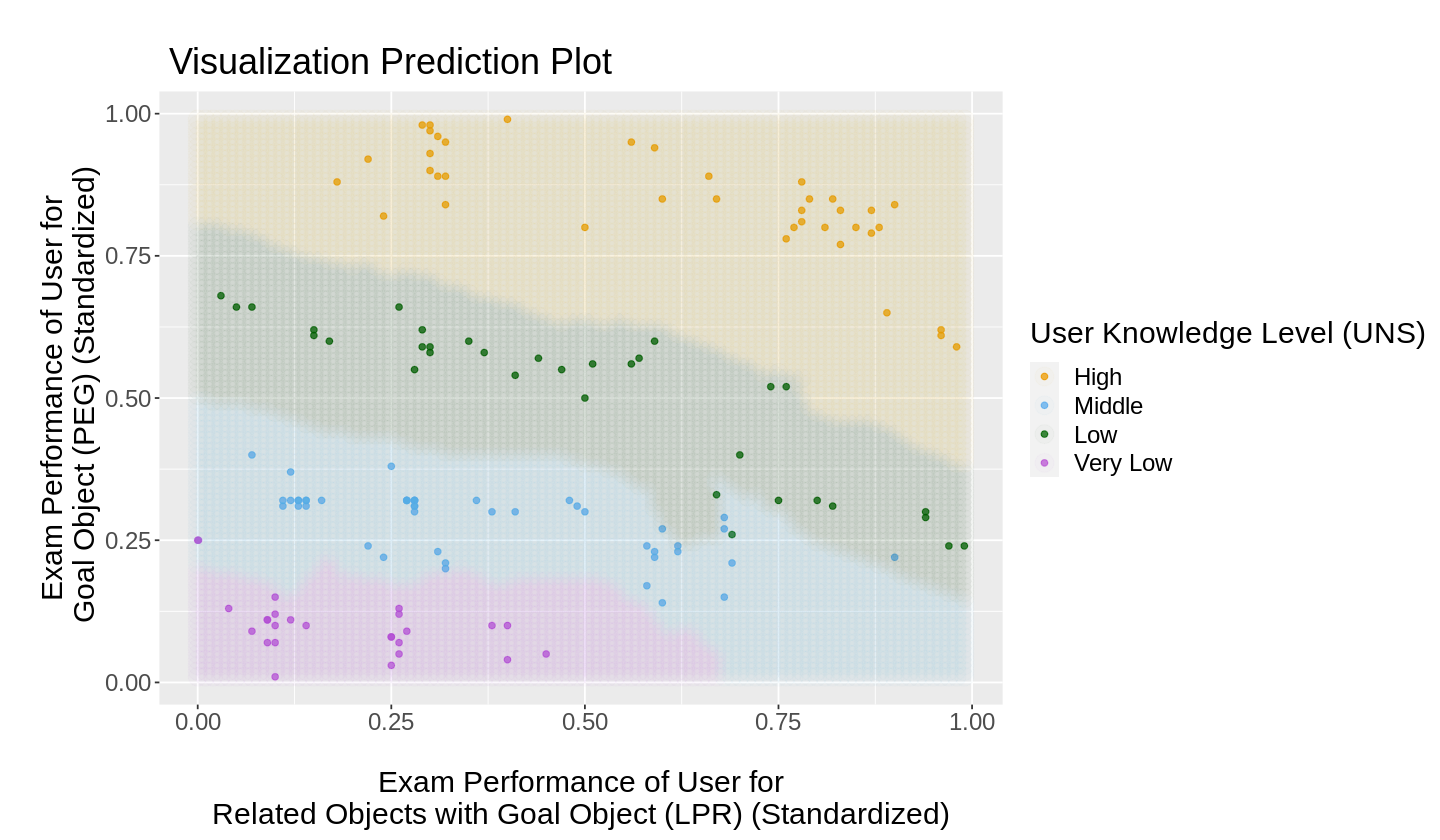

In [19]:
are_grid <- seq(min(testing_data$LPR), 
                max(testing_data$LPR), 
                length.out = 100)
smo_grid <- seq(min(testing_data$PEG), 
                max(testing_data$PEG), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(LPR = are_grid, 
                                PEG = smo_grid))

knnPredGrid <- predict(uk_fit, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
  rename(UNS = .pred_class)

# plot: NEED TO EXPLAIN THIS PLOT IN DETAIL!!! AND NEED TO RENAME THE TITLE!!!!
# 1. the colored scatter of the original data (I think testing data in our case)
# 2. the faded colored scatter for the grid points
options(repr.plot.width = 12, repr.plot.height = 7)

vis_plot <-
  ggplot() +
  geom_point(data = testing_data, 
             mapping = aes(x = LPR, 
                           y = PEG, 
                           color = UNS), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = LPR, 
                           y = PEG, 
                           color = UNS), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "User Knowledge Level (UNS)", 
       x = "\n Exam Performance of User for \nRelated Objects with Goal Object (LPR) (Standardized)", 
       y = "\n Exam Performance of User for \n Goal Object (PEG) (Standardized)",
      title = "\n Visualization Prediction Plot") +
  scale_color_manual(labels = c("High", "Middle", "Low", "Very Low"), 
                     values = c("orange2", "steelblue2", "darkgreen", "mediumorchid")) +
  theme(text = element_text(size = 18))

vis_plot

**Figure 6:** Cloud Plot of the Visualization Prediction of our Model

This cloud plot was generated to visualise our classification model predictions, separating the plot into coloured sections for each knowledge level. We can see that the sections are clearly separated and arranged in the order we would expect (High, Middle, Low, Very Low). Each coloured cloud represents the model’s prediction of the knowledge level of an observation that lands in that region. Lower exam performance correlates to lower knowledge level. This indicates that exam performance is a relatively clear predictor of knowledge level. 

***

### Discussion

##### *What did we find?*
We found that there is a positive correlation between exam performance and knowledge level of a student (lower exam performance means lower knowledge level), which indicates that exam performance is a good predictor of knowledge level.

...

##### *Was this what we expected to find?*
Yes, we expected to find a positive correlation, i.e. better user knowledge for students with greater study times and higher exam performances. This is consistent with the findings of a study carried out by Marcus-Blank et al. (2019) on first year medical school residents, where exam scores were compared with application of skills, which can be interpreted as knowledge level. They found that higher exam scores correlated with better performance, thus knowledge of the subject, in hands-on activities. We also predicted that more time spent on a subject usually means better knowledge, but higher exam scores may be a better predictor of knowledge level. We deduced that this is because it is possible to have poor knowledge of a subject even after spending a lot of time studying it if the individual has an ineffective study strategy, whereas it is necessary to have good knowledge of the subject to get a high score on the exam. In conclusion, our predictions align with our final results as we found study time to be an unreliable and inaccurate predictor of knowledge level, but exam scores have a strong positive relationship with knowledge level (and thus make a good predictor).

...

##### *What impact could these findings have?*
If our prediction is correct, these findings may encourage students to spend more time studying, but also find more efficient ways to study as opposed to just spending a lot of time using ineffective study strategies in order to improve their knowledge level and attain the higher exam scores they may want to achieve. Therefore, the findings could benefit students.

...

##### *What future questions could this lead to?*
* What is the most effective method of studying to consistently yield high exam scores?
* What is the most effective method of studying for individuals to retain information long-term (i.e. maintain high knowledge level)?


### References

Kahraman, H. T., Sagiroglu, S., &amp; Colak, I. (2013). The development of intuitive knowledge classifier and the modeling of Domain Dependent Data. Knowledge-Based Systems, 37, 283–295. https://doi.org/10.1016/j.knosys.2012.08.009 

Marcus-Blank, B., Dahlke, J. A., Braman, J. P., Borman-Shoap, E., Tiryaki, E., Chipman, J., Andrews, J. S., Sackett, P. R., & Cullen, M. J. (2019). Predicting performance of first-year residents. Academic Medicine, 94(3), 378–387. https://doi.org/10.1097/acm.0000000000002429 

Timbers, T. Campbell, T. Lee, M. Peng, R. (2022). Data science: a first introduction. Vancouver, Canada. CRC Press.